## Easy_Evaluation
- まず簡単に評価するには、各PlayIdを1行にする必要がある
- GameIdごとに、Team変数のaway, 


- 多分、座標の使い方はプレー方向によって変わるので、それを考慮した特徴にする

In [47]:
import pandas as pd
import numpy as np
import datetime
import yaml
import argparse
import gc
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

In [48]:
df_train = pd.read_csv('../input/train.csv')
print(df_train.shape)
display(df_train.sample(20))

/home/m-fuj/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(509762, 49)


,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,NflId,DisplayName,JerseyNumber,Season,YardLine,Quarter,GameClock,PossessionTeam,Down,Distance,FieldPosition,HomeScoreBeforePlay,VisitorScoreBeforePlay,NflIdRusher,OffenseFormation,OffensePersonnel,DefendersInTheBox,DefensePersonnel,PlayDirection,TimeHandoff,TimeSnap,Yards,PlayerHeight,PlayerWeight,PlayerBirthDate,PlayerCollegeName,Position,HomeTeamAbbr,VisitorTeamAbbr,Week,Stadium,Location,StadiumType,Turf,GameWeather,Temperature,Humidity,WindSpeed,WindDirection
476198,2018121610,20181216101234,away,69.60,23.40,0.72,1.08,0.10,271.52,165.28,2553632,David Andrews,60,2018,41,2,11:06:00,NE,1,10,NE,14,7,2560809,I_FORM,"2 RB, 1 TE, 2 WR",7.0,"3 DL, 4 LB, 4 DB",left,2018-12-16T22:12:56.000Z,2018-12-16T22:12:55.000Z,3,6-3,300,07/10/1992,Georgia,C,PIT,NE,15,Heinz Field,"Pittsburgh, PA",Outdoors,Grass,Cloudy,42.0,90.0,5,From NNW
239577,2017122408,20171224083061,home,76.94,30.26,1.51,0.81,0.22,42.35,218.85,2555240,Matthew Ioannidis,98,2017,32,4,11:29:00,DEN,2,8,DEN,20,3,2540269,I_FORM,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 4 LB, 5 DB",left,2017-12-24T20:19:47.000Z,2017-12-24T20:19:45.000Z,11,6-3,310,01/11/1994,Temple,DE,WAS,DEN,16,FedExField,"Landover, MD",Outdoor,Grass,Cloudy,43.0,59.0,7,NE
424773,2018112505,20181125050972,home,63.08,32.30,4.04,2.23,0.40,106.19,166.35,2553744,Eric Tomlinson,83,2018,45,2,15:00:00,NYJ,2,6,NE,7,7,2550189,SINGLEBACK,"1 RB, 2 TE, 2 WR",7.0,"3 DL, 3 LB, 5 DB",right,2018-11-25T18:40:36.000Z,2018-11-25T18:40:34.000Z,3,6-6,263,04/22/1992,Texas-El Paso,TE,NYJ,NE,12,MetLife,"East Rutherford, NJ",Outdoor,FieldTurf,Partly Cloudy,54.0,64.0,8,NNW
374214,2018102809,20181028090601,home,105.21,26.67,1.32,3.07,0.12,286.82,311.71,2552626,D.J. Humphries,74,2018,5,1,04:58:00,ARZ,2,10,ARZ,0,0,2553435,JUMBO,"1 RB, 3 TE, 1 WR",8.0,"4 DL, 3 LB, 4 DB",left,2018-10-28T20:46:50.000Z,2018-10-28T20:46:49.000Z,3,6-5,307,12/28/1993,Florida,OT,ARI,SF,8,State Farm Stadium,"Glendale, AZ",Dome,Grass,N/A Indoor,NaN,0.0,NaN,NaN
105539,2017102210,20171022103242,away,51.66,34.17,0.92,2.54,0.03,89.65,182.34,2550541,Shaquil Barrett,48,2017,41,4,07:14:00,LAC,1,10,DEN,14,0,2552469,I_FORM,"2 RB, 2 TE, 1 WR",9.0,"3 DL, 4 LB, 4 DB",left,2017-10-22T22:53:19.000Z,2017-10-22T22:53:18.000Z,2,6-2,250,11/17/1992,Colorado State,OLB,LAC,DEN,7,StubHub Center,"Carson, CA",NaN,Grass,Sunny,90.0,15.0,4,W
299888,2018092307,20180923071421,away,56.17,15.67,7.17,0.57,0.72,111.37,160.95,2552647,Marcus Murphy,45,2018,48,2,08:59:00,BUF,2,10,MIN,0,24,2552647,PISTOL,"2 RB, 1 TE, 2 WR",7.0,"4 DL, 2 LB, 5 DB",right,2018-09-23T18:06:23.000Z,2018-09-23T18:06:20.000Z,4,5-9,195,10/03/1991,Missouri,RB,MIN,BUF,3,U.S. Bank Stadium,"Minneapolis, MN",Indoors,Field Turf,N/A (Indoors),NaN,0.0,NaN,NaN
414262,2018111809,20181118091548,away,74.13,10.72,3.31,2.92,0.31,298.42,312.33,2533039,Alshon Jeffery,17,2018,35,2,06:54:00,PHI,1,10,PHI,17,7,2560949,SHOTGUN,"1 RB, 1 TE, 3 WR",7.0,"4 DL, 2 LB, 5 DB",left,2018-11-18T22:33:09.000Z,2018-11-18T22:33:07.000Z,6,6-3,218,02/14/1990,South Carolina,WR,NO,PHI,11,Mercedes-Benz Superdome,"New Orleans, LA",Dome,UBU Speed Series-S5-M,Indoors,68.0,54.0,4,E
184398,2017120303,20171203032108,home,61.90,24.91,3.17,1.50,0.40,309.36,27.93,2540200,Dion Sims,88,2017,46,3,11:48:00,CHI,1,10,SF,14,9,2555418,I_FORM,"2 RB, 1 TE, 2 WR",8.0,"4 DL, 3 LB, 4 DB",right,2017-12-03T19:43:17.000Z,2017-12-03T19:43:15.000Z,2,6-4,268,02/18/1991,Michigan State,TE,CHI,SF,13,Soldier Field,"Chicago, IL",Outdoor,Grass,Sunny,54.0,44.0,6,SSW
386249,2018110408,20181104080305,home,80.78,13.92,4.73,3.91,0.46,78.33,113.52,2552430,Tyler Lockett,16,2018,29,1,09:49:00,SEA,3,1,LAC,0,0,2558865,SHOTGUN,"6 OL, 1 RB, 1 TE, 2 WR",7.0,"3 DL, 4 LB, 4 DB",right,2018-11-04T21:13:23.000Z,2018-11-04T21:13:21.000Z,8,5-10,182,09/28/1992,Kansas State,WR,SEA,LAC,9,CenturyLink Field,Seattle,Outdoor,FieldTurf,Sunny,56.0,78.0,4,SSE
205940,2017121008,20171210083266,home,98.57,23.45,6.94,2.32,0.72,276.20,1.01,2558208,Chad Williams,16,2017,15,4,09:59:00,ARZ,1,10,ARZ,6,7,2558

In [7]:
df_train.select_dtypes('object')

,Team,DisplayName,GameClock,PossessionTeam,FieldPosition,OffenseFormation,OffensePersonnel,DefensePersonnel,PlayDirection,TimeHandoff,TimeSnap,PlayerHeight,PlayerBirthDate,PlayerCollegeName,Position,HomeTeamAbbr,VisitorTeamAbbr,Stadium,Location,StadiumType,Turf,GameWeather,WindSpeed,WindDirection
0,away,Eric Berry,14:14:00,NE,NE,SHOTGUN,"1 RB, 1 TE, 3 WR","2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,6-0,12/29/1988,Tennessee,SS,NE,KC,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,8,SW
1,away,Allen Bailey,14:14:00,NE,NE,SHOTGUN,"1 RB, 1 TE, 3 WR","2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,6-3,03/25/1989,Miami,DE,NE,KC,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,8,SW
2,away,Justin Houston,14:14:00,NE,NE,SHOTGUN,"1 RB, 1 TE, 3 WR","2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,6-3,01/21/1989,Georgia,DE,NE,KC,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,8,SW
3,away,Derrick Johnson,14:14:00,NE,NE,SHOTGUN,"1 RB, 1 TE, 3 WR","2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,6-3,11/22/1982,Texas,ILB,NE,KC,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,8,SW
4,away,Ron Parker,14:14:00,NE,NE,SHOTGUN,"1 RB, 1 TE, 3 WR","2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,6-0,08/17/1987,Newberry,FS,NE,KC,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,8,SW
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
509757,home,Nick Vannett,00:16:00,SEA,ARZ,SINGLEBACK,"6 OL, 1 RB, 2 TE, 1 WR","4 DL, 3 LB, 4 DB",right,2018-12-31T00:24:51.000Z,2018-12-31T00:24:49.000Z,6-6,03/06/1993,Ohio State,TE,SEA,ARI,CenturyLink Field,"Seattle, WA",Outdoor,FieldTurf,Cloudy,5,SE
509758,home,Germain Ifedi,00:16:00,SEA,ARZ,SINGLEBACK,"6 OL, 1 RB, 2 TE, 1 WR","4 DL, 3 LB, 4 DB",right,2018-12-31T00:24:51.000Z,2018-12-31T00:24:49.000Z,6-5,06/02/1994,Texas A&M,G,SEA,ARI,CenturyLink Field,"Seattle, WA",Outdoor,FieldTurf,Cloudy,5,SE
509759,home,George Fant,00:16:00,SEA,ARZ,SINGLEBACK,"6 OL, 1 RB, 2 TE, 1 WR","4 DL, 3 LB, 4 DB",right,2018-12-31T00:24:51.000Z,2018-12-31T00:24:49.000Z,6-5,07/19/1992,Western Kentucky,OT,SEA,ARI,CenturyLink Field,"Seattle, WA",Outdoor,FieldTurf,Cloudy,5,SE
509760,home,Ethan Pocic,00:16:00,SEA,ARZ,SINGLEBACK,"6 OL, 1 RB, 2 TE, 1 WR","4 DL, 3 LB, 4 DB",right,2018-12-31T00:24:51.000Z,2018-12-31T00:24:49.000Z,6-6,08/05/1995,Louisiana State,C,SEA,ARI,CenturyLink Field,"Seattle, WA",Outdoor,FieldTurf,Cloudy,5,SE


In [9]:
df_train[['WindSpeed']].dtypes

WindSpeed    object
dtype: object

In [4]:
df_train['WindSpeed'].value_counts(dropna=False)

NaN                  67430
5.0                  26686
7.0                  26642
5                    26598
6.0                  22800
9.0                  19920
4                    19844
10.0                 19568
6                    18780
8.0                  18348
2.0                  17520
12.0                 17226
3                    15840
4                    14740
11.0                 14496
7                    12936
9                    11408
8                    11022
3                    11022
10                   10220
15.0                  7964
0                     7656
13                    7348
1                     6776
2                     6592
12                    6358
0.0                   6116
15                    5962
16.0                  5962
1                     5302
14.0                  4154
16                    3916
11                    2620
17.0                  2046
18.0                  1980
14                    1940
17                    1826
1

In [33]:
(22+12)/2

17.0

In [36]:
windspeed_dict = {'13 MPH':13,'E':5,'SE':5,'10-20':(10+20)/2,'7 MPH':7,'Calm':5,'12-22':(12+22)/2,'6 mph':6,'12mph':12,'14-23':(14+23)/2,'10mph':10,'4 MPh':4,'10MPH':10,'SSW':5,'15 gusts up to 25':20,'11-17':(11+17)/2}
df_train['WindSpeed'] = df_train['WindSpeed'].replace(windspeed_dict)
df_train['WindSpeed'] = df_train['WindSpeed'].astype('float')
df_train['WindSpeed'].value_counts(dropna=False)

NaN     67430
5.0     57486
6.0     42614
7.0     40678
4.0     35486
10.0    31592
9.0     31328
8.0     29370
3.0     26862
12.0    24552
2.0     24112
11.0    17116
15.0    15026
0.0     13772
1.0     12078
13.0    10208
16.0     9878
14.0     6820
17.0     4928
18.0     1980
20.0     1848
23.0     1166
24.0      968
18.5      968
22.0      836
19.0      660
Name: WindSpeed, dtype: int64

In [40]:
# だいたいの年齢
df_train['PlayerBirthDate'] = pd.to_datetime(df_train['PlayerBirthDate'])
df_train['year'] = 2019 - df_train['PlayerBirthDate'].dt.year
df_train['year'].value_counts(dropna=False)

27    63736
26    62590
28    59106
25    56920
29    48823
30    48520
24    41300
31    35640
32    22683
23    16021
33    14675
34    10969
35     7040
36     6740
22     5195
37     3353
38     3028
40     1221
39      866
42      823
21      343
41      170
Name: year, dtype: int64

In [54]:
df_train['GameClock'].value_counts().sort_index()

00:00:00       22
00:01:00      110
00:02:00      220
00:03:00      352
00:04:00      352
            ...  
14:56:00     1276
14:57:00      462
14:58:00       88
14:59:00       66
15:00:00    14476
Name: GameClock, Length: 901, dtype: int64

In [52]:
df_train[df_train['GameId']==2018090911]['GameClock'].value_counts().sort_index()

00:45:00    22
01:22:00    22
01:40:00    22
01:55:00    22
02:00:00    22
02:20:00    22
02:24:00    22
02:55:00    22
03:10:00    22
03:16:00    22
03:28:00    22
03:41:00    22
04:40:00    22
04:58:00    22
05:04:00    22
05:26:00    22
05:29:00    22
06:02:00    22
06:03:00    22
06:16:00    22
06:39:00    22
06:50:00    22
06:52:00    22
07:17:00    22
07:31:00    22
07:57:00    22
07:58:00    22
08:22:00    22
08:39:00    22
09:57:00    22
10:43:00    22
10:48:00    22
11:18:00    22
11:19:00    22
12:00:00    22
12:38:00    22
12:48:00    22
13:10:00    22
13:51:00    22
13:59:00    22
14:13:00    22
14:46:00    22
14:55:00    22
14:57:00    22
15:00:00    22
Name: GameClock, dtype: int64

In [62]:
df_train['GameClock_sec'] = pd.to_datetime(df_train['GameClock']).dt.minute*60 + pd.to_datetime(df_train['GameClock']).dt.second
df_train['GameClock_sec']

0         840
1         840
2         840
3         840
4         840
         ... 
509757    960
509758    960
509759    960
509760    960
509761    960
Name: GameClock_sec, Length: 509762, dtype: int64

In [65]:
def height2cm(h):
    return int(h[0]) * 30.48 + int(h[2]) * 2.58

df_train['PlayerHeight_cm'] = df_train['PlayerHeight'].map(height2cm)
df_train['PlayerHeight_cm']

0         182.88
1         190.62
2         190.62
3         190.62
4         182.88
           ...  
509757    198.36
509758    195.78
509759    195.78
509760    198.36
509761    154.98
Name: PlayerHeight_cm, Length: 509762, dtype: float64

In [41]:
cols_cat = df_train.select_dtypes('object')
cols_cat

,Team,DisplayName,GameClock,PossessionTeam,FieldPosition,OffenseFormation,OffensePersonnel,DefensePersonnel,PlayDirection,TimeHandoff,TimeSnap,PlayerHeight,PlayerCollegeName,Position,HomeTeamAbbr,VisitorTeamAbbr,Stadium,Location,StadiumType,Turf,GameWeather,WindDirection
0,away,Eric Berry,14:14:00,NE,NE,SHOTGUN,"1 RB, 1 TE, 3 WR","2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,6-0,Tennessee,SS,NE,KC,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,SW
1,away,Allen Bailey,14:14:00,NE,NE,SHOTGUN,"1 RB, 1 TE, 3 WR","2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,6-3,Miami,DE,NE,KC,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,SW
2,away,Justin Houston,14:14:00,NE,NE,SHOTGUN,"1 RB, 1 TE, 3 WR","2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,6-3,Georgia,DE,NE,KC,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,SW
3,away,Derrick Johnson,14:14:00,NE,NE,SHOTGUN,"1 RB, 1 TE, 3 WR","2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,6-3,Texas,ILB,NE,KC,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,SW
4,away,Ron Parker,14:14:00,NE,NE,SHOTGUN,"1 RB, 1 TE, 3 WR","2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,6-0,Newberry,FS,NE,KC,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,SW
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
509757,home,Nick Vannett,00:16:00,SEA,ARZ,SINGLEBACK,"6 OL, 1 RB, 2 TE, 1 WR","4 DL, 3 LB, 4 DB",right,2018-12-31T00:24:51.000Z,2018-12-31T00:24:49.000Z,6-6,Ohio State,TE,SEA,ARI,CenturyLink Field,"Seattle, WA",Outdoor,FieldTurf,Cloudy,SE
509758,home,Germain Ifedi,00:16:00,SEA,ARZ,SINGLEBACK,"6 OL, 1 RB, 2 TE, 1 WR","4 DL, 3 LB, 4 DB",right,2018-12-31T00:24:51.000Z,2018-12-31T00:24:49.000Z,6-5,Texas A&M,G,SEA,ARI,CenturyLink Field,"Seattle, WA",Outdoor,FieldTurf,Cloudy,SE
509759,home,George Fant,00:16:00,SEA,ARZ,SINGLEBACK,"6 OL, 1 RB, 2 TE, 1 WR","4 DL, 3 LB, 4 DB",right,2018-12-31T00:24:51.000Z,2018-12-31T00:24:49.000Z,6-5,Western Kentucky,OT,SEA,ARI,CenturyLink Field,"Seattle, WA",Outdoor,FieldTurf,Cloudy,SE
509760,home,Ethan Pocic,00:16:00,SEA,ARZ,SINGLEBACK,"6 OL, 1 RB, 2 TE, 1 WR","4 DL, 3 LB, 4 DB",right,2018-12-31T00:24:51.000Z,2018-12-31T00:24:49.000Z,6-6,Louisiana State,C,SEA,ARI,CenturyLink Field,"Seattle, WA",Outdoor,FieldTurf,Cloudy,SE


In [67]:
cols_rm = ['DisplayName','GameClock','TimeHandoff','TimeSnap','PlayerHeight','PlayerCollegeName','Stadium','Location']
for col in cols_cat:
    if col not in cols_rm:
        print(col, df_train[col].nunique())

Team 2
PossessionTeam 32
FieldPosition 32
OffenseFormation 8
OffensePersonnel 56
DefensePersonnel 38
PlayDirection 2
Position 25
HomeTeamAbbr 32
VisitorTeamAbbr 32
StadiumType 29
Turf 20
GameWeather 61
WindDirection 53


In [14]:
df_train.groupby(['GameId', 'PlayId', 'Team', 'OffensePersonnel']).count()

X   Y   S   A  Dis  \
GameId     PlayId         Team OffensePersonnel                              
2017090700 20170907000118 away 1 RB, 1 TE, 3 WR        11  11  11  11   11   
                          home 1 RB, 1 TE, 3 WR        11  11  11  11   11   
           20170907000139 away 1 RB, 1 TE, 3 WR        11  11  11  11   11   
                          home 1 RB, 1 TE, 3 WR        11  11  11  11   11   
           20170907000189 away 1 RB, 1 TE, 3 WR        11  11  11  11   11   
...                                                    ..  ..  ..  ..  ...   
2018123015 20181230154082 home 1 RB, 1 TE, 3 WR        11  11  11  11   11   
           20181230154135 away 1 RB, 1 TE, 3 WR        11  11  11  11   11   
                          home 1 RB, 1 TE, 3 WR        11  11  11  11   11   
           20181230154157 away 6 OL, 1 RB, 2 TE, 1 WR  11  11  11  11   11   
                          home 6 OL, 1 RB, 2 TE, 1 WR  11  11  11  11   11   

                                                       Orientation  Dir  \
GameId     PlayId         Team OffensePersonnel                           
2017090700 20170907000118 away 1 RB, 1 TE, 3 WR                 11   11   
                          home 1 RB, 1 TE, 3 WR                 11   11   
           20170907000139 away 1 RB, 1 TE, 3 WR                 11   11   
                          home 1 RB, 1 TE, 3 WR                 11   11   
           20170907000189 away 1 RB, 1 TE, 3 WR                 11   11   
...                                                            ...  ...   
2018123015 20181230154082 home 1 RB, 1 TE, 3 WR                 11   11   
           20181230154135 away 1 RB, 1 TE, 3 WR                 11   11   
                          home 1 RB, 1 TE, 3 WR                 11   11   
           20181230154157 away 6 OL, 1 RB, 2 TE, 1 WR           11   11   
                          home 6 OL, 1 RB, 2 TE, 1 WR           11   11   

                                                       NflId  DisplayName  \
GameId     PlayId         Team OffensePersonnel                             
2017090700 20170907000118 away 1 RB, 1 TE, 3 WR           11           11   
                          home 1 RB, 1 TE, 3 WR           11           11   
           20170907000139 away 1 RB, 1 TE, 3 WR           11           11   
                          home 1 RB, 1 TE, 3 WR           11           11   
           20170907000189 away 1 RB, 1 TE, 3 WR           11           11   
...                                                      ...          ...   
2018123015 20181230154082 home 1 RB, 1 TE, 3 WR           11           11   
           20181230154135 away 1 RB, 1 TE, 3 WR           11           11   
                          home 1 RB, 1 TE, 3 WR           11           11   
           20181230154157 away 6 OL, 1 RB, 2 TE, 1 WR     11           11   
                          home 6 OL, 1 RB, 2 TE, 1 WR     11           11   

                                                       JerseyNumber  Season  \
GameId     PlayId         Team OffensePersonnel                               
2017090700 20170907000118 away 1 RB, 1 TE, 3 WR                  11      11   
                          home 1 RB, 1 TE, 3 WR                  11      11   
           20170907000139 away 1 RB, 1 TE, 3 WR                  11      11   
                          home 1 RB, 1 TE, 3 WR                  11      11   
           20170907000189 away 1 RB, 1 TE, 3 WR                  11      11   
...                                                             ...     ...   
2018123015 20181230154082 home 1 RB, 1 TE, 3 WR                  11      11   
           20181230154135 away 1 RB, 1 TE, 3 WR                  11      11   
                          home 1 RB, 1 TE, 3 WR                  11      11   
           20181230154157 away 6 OL, 1 RB, 2 TE, 1 WR            11      11   
                          home 6 OL, 1 RB, 2 TE, 1 WR            11      11   

                                   

### GameIDごとのPlayIdの数

GameId
2017090700    1144
2017091000     968
2017091001     836
2017091002    1386
2017091003     726
              ... 
2018123011     924
2018123012     858
2018123013    1056
2018123014    1342
2018123015    1232
Name: PlayId, Length: 512, dtype: int64

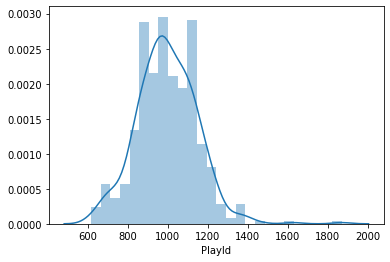

In [17]:
plays_per_game = df_train.groupby('GameId')['PlayId'].count()
display(plays_per_game)
sns.distplot(plays_per_game)

### 目的変数Yardsとの関係

In [ ]:
df_train['Yards']